In [4]:
import yaml
from Pricing4API.ancillary.yaml_serialization import PricingYamlHandler
from Pricing4API.ancillary.limit import Limit
from Pricing4API.ancillary.time_unit import TimeDuration, TimeUnit
from Pricing4API.main.plan import Plan
from Pricing4API.main.subscription import Subscription
from Pricing4API.utils import format_time_with_unit
PricingYamlHandler.load()

## Propósito del Notebook

El propósito de este notebook es comparar los dos planes que ofrece Amadeus: **Test** y **Production**.

En la siguiente imagen destacamos las principales diferencias entre estos planes, que se encuentran principalmente en sus **límites de rate**:
- El **Plan Test** nos limita a **10 solicitudes por segundo**, con un **rate unitario** (separación entre dos llamadas consecutivas) de **100ms**.
- El **Plan Production** permite **40 solicitudes por segundo**, con llamadas ilimitadas si optamos por costos de excedente (*overage cost*). Sin embargo, para simplificar, los ignoraremos en este ejemplo.

Nuestro objetivo es modelar y analizar estos planes para entender mejor cómo se comportan las APIs bajo diferentes condiciones.


<img src="image-20250116-132317.png" width="100%" align="left" />

<img src="image-20250115-012858.png" width="50%" align="" />

La API de Amadeus ofrece diferentes cuotas para diferentes endpoints, en concreto estaremos "probando"la capacidad para el endpoint `/v1/booking/flight-orders`, que nos permite realizar **10000 llamadas al mes**. Este dato no aparecerá en el YAML del Pricing, se usará el **globbing** por simplicidad, pero debería ser configurable en el futuro.

##### **Uso del 'globbing'**

El uso de **/*** indica que aplica a todos los endpoints, y el uso de **all** que aplica a todo metodo HTTP. En este caso se deja así por simplificar la construcción.>

In [5]:
amadeus_yaml = """
!Pricing
Amadeus Pricing:
  metrics:
    name: requests
  plans:
    Test Enviroment:
      cost: 0.0
      billing_cycle:
        value: 1
        unit: month
      unitary_rate: 
        /*:
          all:
            requests:
              period:
                value: 100
                unit: millisecond
      quotas:
        /*:
          all:
            requests:
              - max: 10
                period:
                  value: 1
                  unit: second
              - max: 10000
                period:
                  value: 1
                  unit: month
    Production Enviroment:
      cost: 0.0
      billing_cycle:
        value: 1
        unit: month
      quotas:
        /*:
          all:
            requests:
              - max: 40
                period:
                  value: 1
                  unit: second
              - max: 10000
                period:
                  value: 1
                  unit: month
                  
"""

In [6]:
pricing_amadeus = yaml.safe_load(amadeus_yaml)

planes = pricing_amadeus.plans

for index, plan in enumerate(planes):
    print(plan.name,"--- index: " , index)

Test Enviroment --- index:  0
Production Enviroment --- index:  1


In [7]:
test_amadeus = planes[0] #type: Plan
production_amadeus = planes[1] #type: Plan

In [ ]:

time_simulation = TimeDuration(1, TimeUnit.MONTH) + TimeDuration(10, TimeUnit.SECOND)
test_amadeus.show_capacity_areas(time_simulation)
#production_amadeus.show_available_capacity_curve(time_simulation)
# Este bloque de código puede tardar varios minutos, e incluso fallar, se está desarrollando una versión optimizada de este método.
# Si se desea, se puede saltar este paso e ir al siguiente bloque de código.
# Si lo ejecutaste y deseas pararlo y no se consigue, se recomienda apagar la máquina y volver a encenderla
# (Si lo hace, no olvide instalar las dependencias de nuevo, ejecutando la primera celda de este notebook).

Aparentemente, los planes tienen una curva de capacidad similar, debido a que el rate es muy alto, se permiten hacer muchas llamadas en muy poco tiempo, en comparación a la cuota.

---
Para comprobar las diferencias entre ambos planes, podemos saber cuándo llegaríamos a la máxima cuota si nos mantemos a máxima velocidad. Para ello accedemos al atributo `max_quota_burning_time` de cada plan.

In [27]:
# La función format_time_with_unit muestra un tiempo en formato de HH:MM:SS, está en proceso de implementación en la clase.

print(format_time_with_unit(test_amadeus.max_quota_burning_time))
print(format_time_with_unit(production_amadeus.max_quota_burning_time))

16m39s
4m9s


El resultado anterior nos indica que en 16 minutos y 39 segundos acabaríamos con la cuota de 100000 peticiones para el plan Test, y en 4 minutos y 9 segundos para el plan Production. Comparemos ahora las curvas de **capacidad ideal** de ambos planes tras 20 minutos de simulación.

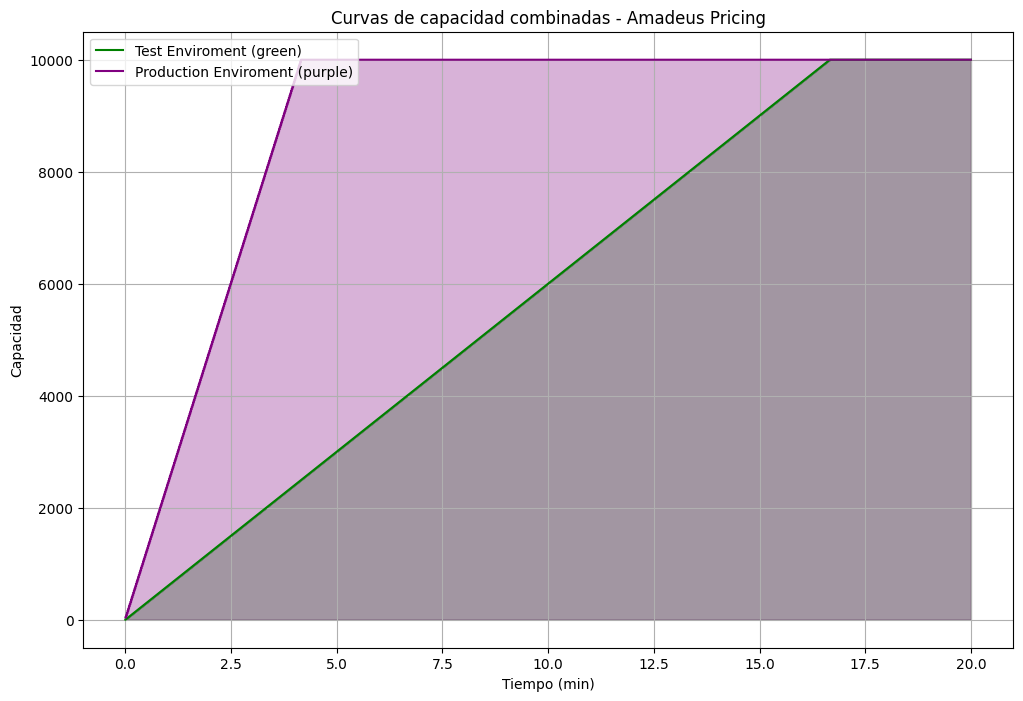

In [9]:
time_simulation = TimeDuration(20, TimeUnit.MINUTE)
pricing_amadeus.show_combined_capacity_curves(time_simulation)

La diferencia en la pendiente indica que el plan Production es mas veloz que el plan Test, también la diferencia radica en el tamaño de los escalones, imperceptible a la vista con esta escala. Probemos a simular un par de segundos.

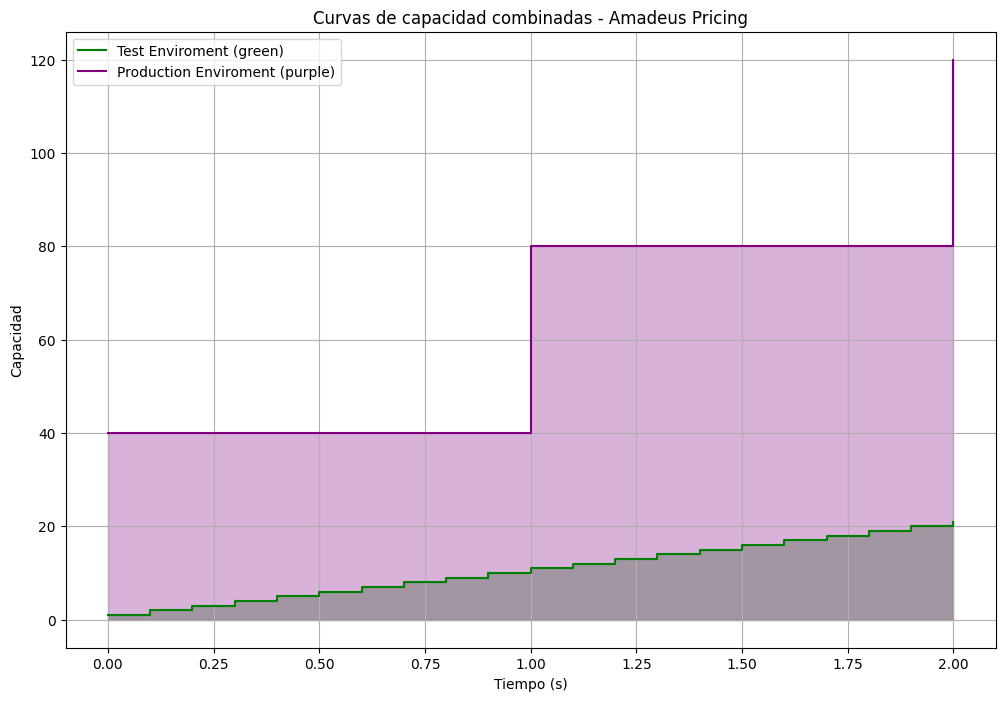

In [9]:
time_simulation = TimeDuration(2, TimeUnit.SECOND)
pricing_amadeus.show_combined_capacity_curves(time_simulation)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bfc07943-bcc8-48e2-8be3-26469867b14f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>